# nvImageCodecs with cuPy

In [1]:
import os
import cv2
import cupy as cp
from matplotlib import pyplot as plt
#os.chdir("c:\\Users\\smatysik\\projects\\nvimagecodecs\\build\\bin\\python")
os.chdir("/mnt/c/Users/smatysik/projects/nvImageCodecsWSL/build/bin/python")
resources_dir = "../../../resources"
import nvimgcodecs


Load 4k, jpeg2000 image with nvImageCodecs

In [6]:
nv_img4k = nvimgcodecs.imread("{}/base/4k_lossless.jp2".format(resources_dir))
print(nv_img4k.__cuda_array_interface__)

{'shape': (3, 2160, 3840), 'strides': (8847360, 4096, 1), 'typestr': '=B', 'data': (34487664640, False), 'version': 2}


Pass nvImageCodecs Image to cupy

In [10]:
%%time
cp_img4k = cp.asarray(nv_img4k)
print(cp_img4k.__cuda_array_interface__)

{'shape': (3, 2160, 3840), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (8847360, 4096, 1), 'data': (34487664640, False)}
CPU times: user 249 µs, sys: 220 µs, total: 469 µs
Wall time: 365 µs


Convert CHW(c-style) = Planar -> HWC (c-style) = Interleave

In [11]:
cp_img4k = cp.moveaxis(cp_img4k, (0, 1, 2), (2, 0, 1))
print(cp_img4k.__cuda_array_interface__)
#Uncoment for packing
# In Fortran the most rapidly changing index comes first
#cp_img4k = cp.asfortranarray(cp_img4k)
# print(cp_img4k.__cuda_array_interface__)
#cp_img4k = cp.ascontiguousarray(cp_img4k)
# print(cp_img4k.__cuda_array_interface__)


{'shape': (2160, 3840, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (4096, 1, 8847360), 'data': (34487664640, False)}


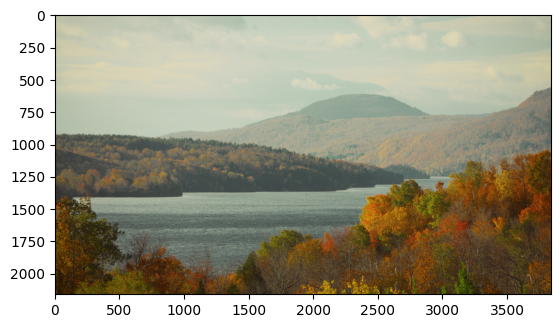

In [12]:
np_img4k = cp.asnumpy(cp_img4k)
plt.imshow(np_img4k)


Lets do some opration on image in GPU using cupyx.scipy

In [13]:
import cupyx.scipy.ndimage

In [14]:
cp_img_4k_rotated = cupyx.scipy.ndimage.rotate(cp_img4k, 90)
cp_img_4k_gaussian = cupyx.scipy.ndimage.gaussian_filter(cp_img4k, sigma = 15)
cp_img_4k_laplace = cupyx.scipy.ndimage.laplace(cp_img4k)

print(cp_img_4k_rotated.__cuda_array_interface__)

{'shape': (3840, 2160, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': None, 'data': (34407972864, False)}


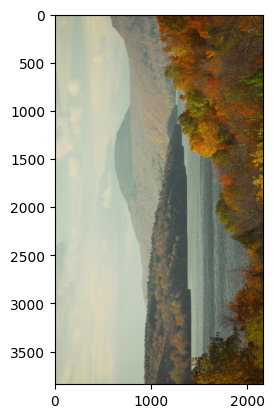

In [15]:
np_img_4k = cp.asnumpy(cp_img_4k_rotated)
plt.imshow(np_img_4k)

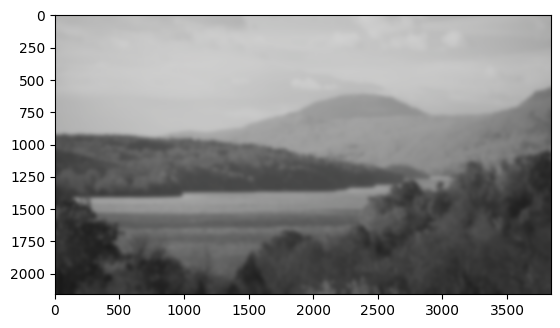

In [16]:
np_img_4k = cp.asnumpy(cp_img_4k_gaussian)
plt.imshow(np_img_4k)


Save as JPEG2000

nvJpeg2000 now supports only Planar RGB and cupy ndarray is in interleaved RGB format so we need to convert it before providing buffer to nvJpeg2000. In future nvJpeg2000 should probably support I_RGB.

In [18]:
# HWC (C-style = row-major) = interleaved -> CHW (C-style) = planar
print(cp_img_4k_rotated.__cuda_array_interface__)

cp_img_4k_rotated_planar = cp.moveaxis(cp_img_4k_rotated, (0, 1, 2), (1, 0, 2))
print(cp_img_4k_rotated_planar.__cuda_array_interface__)

cp_img_4k_rotated_planar = cp.asfortranarray(cp_img_4k_rotated_planar)
print(cp_img_4k_rotated_planar.__cuda_array_interface__)


cp_img_4k_rotated_planar = cp.moveaxis(cp_img_4k_rotated_planar, (0, 1, 2), (2, 1, 0))
print(cp_img_4k_rotated_planar.__cuda_array_interface__)


{'shape': (3840, 2160, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': None, 'data': (34407972864, False)}
{'shape': (2160, 3840, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (3, 6480, 1), 'data': (34407972864, False)}
{'shape': (2160, 3840, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (1, 2160, 8294400), 'data': (34460401664, False)}
{'shape': (3, 3840, 2160), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': None, 'data': (34460401664, False)}


In [19]:
%%time
nv_rotated_img = nvimgcodecs.asimage(cp_img_4k_rotated_planar)


CPU times: user 64 µs, sys: 39 µs, total: 103 µs
Wall time: 105 µs


In [20]:
%%time
nvimgcodecs.imwrite("rotated.j2k", nv_rotated_img)


CPU times: user 586 ms, sys: 11.7 ms, total: 598 ms
Wall time: 639 ms


Load with OpenCv to verify

[ WARN:0@447.871] global /io/opencv/modules/imgcodecs/src/grfmt_jpeg2000_openjpeg.cpp (607) readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed


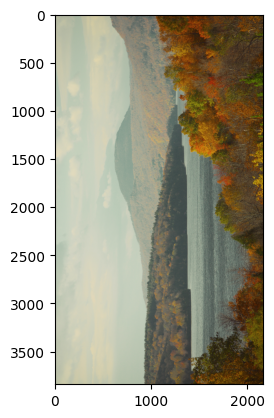

In [21]:
image = cv2.imread("rotated.j2k")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Save cupy image to jpg with nvImageCodecs

In [22]:
%%time
nvimgcodecs.imwrite("rotated.jpg", nv_rotated_img)


CPU times: user 97.7 ms, sys: 23.2 ms, total: 121 ms
Wall time: 153 ms


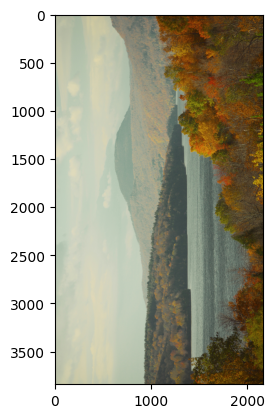

In [23]:
image = cv2.imread("rotated.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)